# Import Libraries and Seed

In [ ]:
%pip install optuna

import os
import csv
import math
import time
import random
import itertools

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import optuna

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Import Dataset

In [ ]:
# Load CIFAR-10 data to compute mean and standard deviation
cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

mean = torch.zeros(3)
std = torch.zeros(3)

for img, _ in cifar10:
    mean += img.mean([1, 2])
    std += img.std([1, 2])

mean /= len(cifar10)
std /= len(cifar10)

mean_tuple = tuple(mean.numpy())
std_tuple = tuple(std.numpy())

# Transformations for training data with advanced augmentations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_tuple, std_tuple)
])

# Transformations for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_tuple, std_tuple)
])

# Load training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:03<00:00, 50.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# Performer RELU

In [ ]:
class PerformerLayer(nn.Module):
    def __init__(self, dim, n_heads, nb_features=256, dropout=0.1):
        super(PerformerLayer, self).__init__()
        self.dim = dim
        self.n_heads = n_heads
        self.head_dim = dim // n_heads
        self.nb_features = nb_features

        assert self.head_dim * n_heads == dim, "dim must be divisible by n_heads"

        # Linear projections for q, k, v
        self.to_q = nn.Linear(dim, dim, bias=False)
        self.to_k = nn.Linear(dim, dim, bias=False)
        self.to_v = nn.Linear(dim, dim, bias=False)
        self.to_out = nn.Linear(dim, dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(dim)
        self.layer_norm2 = nn.LayerNorm(dim)

        # Random projection matrix for FAVOR+
        self.register_buffer('projection_matrix', self.create_projection())

    def create_projection(self):
        # Orthogonal random features as per Performer paper
        projection_matrix_shape = (self.nb_features, self.head_dim)
        projection_matrix = torch.randn(projection_matrix_shape)
        torch.nn.init.orthogonal_(projection_matrix)
        return projection_matrix

    def generalized_kernel(self, data):
        # data: (batch_size, n_heads, seq_length, head_dim)
        projection = self.projection_matrix.to(data.device)  # (nb_features, head_dim)
        data = data / math.sqrt(self.head_dim)
        data_dash = torch.einsum('b h s d, f d -> b h s f', data, projection)
        data_prime = F.relu(data_dash) + 1e-6 # RELU
        return data_prime

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)

        batch_size, seq_length, dim = x.size()

        # Compute queries, keys, and values
        q = self.to_q(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.to_k(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.to_v(x).view(batch_size, seq_length, self.n_heads, self.head_dim).transpose(1, 2)

        # q, k, v: (batch_size, n_heads, seq_length, head_dim)

        # Apply the random feature map (FAVOR+)
        q_prime = self.generalized_kernel(q)  # (batch_size, n_heads, seq_length, nb_features)
        k_prime = self.generalized_kernel(k)  # (batch_size, n_heads, seq_length, nb_features)

        # Compute attention using FAVOR+
        kv = torch.einsum('b h s f, b h s d -> b h f d', k_prime, v)  # (batch_size, n_heads, nb_features, head_dim)

        k_prime_sum = k_prime.sum(dim=2)  # (batch_size, n_heads, nb_features)
        z_denominator = torch.einsum('b h s f, b h f -> b h s', q_prime, k_prime_sum) + 1e-6  # (batch_size, n_heads, seq_length)
        z = 1 / z_denominator

        out = torch.einsum('b h s f, b h f d -> b h s d', q_prime, kv)  # (batch_size, n_heads, seq_length, head_dim)
        out = out * z.unsqueeze(-1)

        # Reshape and combine heads
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, dim)
        out = self.to_out(out)
        out = self.dropout(out)

        # Residual connection and layer normalization
        out = residual + out
        out = self.layer_norm2(out)

        return out

In [ ]:
class Performer(nn.Module):
    def __init__(self, dim, n_heads, depth, dropout, num_classes=10, nb_features=256):
        super(Performer, self).__init__()

        self.dim = dim
        self.nb_features = nb_features

        # Initial convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2),
        )

        # Flattening and embedding
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )

        # Performer layers
        self.performer_layers = nn.ModuleList([
            PerformerLayer(dim, n_heads, nb_features=nb_features, dropout=dropout) for _ in range(depth)
        ])

        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv_layers(x)

        # Embed features
        x = self.embedding(x).unsqueeze(1)  # Shape: (batch_size, seq_length=1, dim)

        # Apply Performer layers
        for performer_layer in self.performer_layers:
            x = performer_layer(x)

        # Remove sequence dimension and classify
        x = x.squeeze(1)
        x = self.classifier(x)

        return x

# Train Model

In [ ]:
def train_model(model, trainloader, criterion, optimizer, scheduler, device, num_epochs):
    model.to(device)
    start_time = time.time()  # Start timing

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(trainloader, desc=f'Epoch [{epoch+1}/{num_epochs}]', leave=False)

        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        scheduler.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}")

    training_time = time.time() - start_time  # End timing
    print(f"Training Time: {training_time:.2f} seconds")
    return training_time

# Evaluate Model

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()  # Start timing

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Evaluating", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    inference_time = time.time() - start_time  # End timing
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%, Inference Time: {inference_time:.2f} seconds")
    return accuracy, inference_time

# Validate Model

In [ ]:
def validate_model(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss

# Grid Search for Hyperparameter Tuning

In [ ]:
def hyperparameter_tuning(parameters_to_test, num_epochs, k_folds=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Extract hyperparameter grids
    learning_rates = parameters_to_test['learning_rates']
    batch_sizes = parameters_to_test['batch_sizes']
    dims = parameters_to_test['dims']
    n_heads_list = parameters_to_test['n_heads_list']
    nb_features_list = parameters_to_test['nb_features_list']
    dropout_list = parameters_to_test['dropout']
    depths = parameters_to_test['depths']
    optimizer_funcs = parameters_to_test['optimizers']

    best_accuracy = 0.0
    best_params = {}

    # Compute total configurations for progress tracking
    total_rounds = len(learning_rates) * len(batch_sizes) * len(dims) * len(n_heads_list) * \
                   len(nb_features_list) * len(depths) * len(optimizer_funcs) * len(dropout_list)
    current_round = 0

    # Prepare the CSV file for logging
    csv_file = 'tuning_results.csv'
    file_exists = os.path.isfile(csv_file)
    with open(csv_file, mode='a', newline='') as csvfile:
        fieldnames = ['Round', 'Learning Rate', 'Batch Size', 'Dim', 'Dropout', 'Num Heads',
                      'Num Features', 'Depth', 'Optimizer', 'Num Epochs', 'Accuracy']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # Write the header only once
        if not file_exists:
            writer.writeheader()

        # Iterate over the hyperparameter combinations
        for lr, batch_size, dim, n_heads, nb_features, depth, dropout, optimizer_func in itertools.product(
                learning_rates, batch_sizes, dims, n_heads_list, nb_features_list, depths, dropout_list, optimizer_funcs):

            current_round += 1

            # Skip invalid configurations
            if dim % n_heads != 0:
                print(f"Skipping configuration: dim={dim}, n_heads={n_heads} (not divisible)")
                continue

            print(f"\nTraining Configuration [{current_round}/{total_rounds}]")
            print(f"Learning Rate: {lr}, Batch Size: {batch_size}, Dim: {dim}, Heads: {n_heads}, "
                  f"Features: {nb_features}, Depth: {depth}, Dropout: {dropout}, Optimizer: {optimizer_func}")

            # Initialize variable to accumulate accuracy over folds
            total_accuracy = 0.0

            # Initialize StratifiedKFold
            skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

            # Since trainset.targets is a list, we need to convert it to a numpy array
            targets = np.array(trainset.targets)

            for fold, (train_indices, val_indices) in enumerate(skf.split(np.zeros(len(targets)), targets)):
                print(f"Fold {fold+1}/{k_folds}")

                # Create subsets
                train_subset = torch.utils.data.Subset(trainset, train_indices)
                val_subset = torch.utils.data.Subset(trainset, val_indices)

                # Data loaders
                trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
                valloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

                # Initialize the model with current hyperparameters
                model = Performer(num_classes=10, dim=dim, n_heads=n_heads, depth=depth, dropout=dropout, nb_features=nb_features)
                model.to(device)

                # Set the optimizer and scheduler based on the selected function
                criterion = nn.CrossEntropyLoss()
                if optimizer_func == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
                    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
                elif optimizer_func == 'SGD':
                    lr_sgd = lr * 10  # Adjusting learning rate for SGD
                    optimizer = optim.SGD(model.parameters(), lr=lr_sgd, momentum=0.9, weight_decay=1e-4)
                    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

                # Train the model
                try:
                    train_model(model, trainloader, criterion, optimizer, scheduler, device, num_epochs)
                except RuntimeError as e:
                    print(f"RuntimeError during training: {e}")
                    continue

                # Validate the model
                try:
                    accuracy, _ = evaluate_model(model, valloader, device)
                except RuntimeError as e:
                    print(f"RuntimeError during evaluation: {e}")
                    continue

                print(f"Fold {fold+1}, Accuracy: {accuracy:.2f}%")
                total_accuracy += accuracy

            # Average accuracy over folds
            average_accuracy = total_accuracy / k_folds
            print(f"Average Accuracy over {k_folds} folds: {average_accuracy:.2f}%")

            # Log the results to the CSV file
            writer.writerow({
                'Round': current_round,
                'Learning Rate': lr,
                'Batch Size': batch_size,
                'Dim': dim,
                'Num Heads': n_heads,
                'Num Features': nb_features,
                'Depth': depth,
                'Dropout': dropout,
                'Optimizer': optimizer_func,
                'Num Epochs': num_epochs,
                'Accuracy': average_accuracy
            })

            # Update the best parameters if accuracy improves
            if average_accuracy > best_accuracy:
                best_accuracy = average_accuracy
                best_params = {
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'dim': dim,
                    'dropout': dropout,
                    'n_heads': n_heads,
                    'nb_features': nb_features,
                    'depth': depth,
                    'optimizer': optimizer_func
                }

    print(f"\nBest Average Accuracy: {best_accuracy:.2f}% with Parameters: {best_params}")
    return best_params

In [ ]:
training = False

In [ ]:
if training:
  parameters_to_test_1 = {
      'learning_rates': [2e-3, 1e-3, 5e-4, 1e-4],
      'batch_sizes': [16, 32, 64, 128, 256],
      'dims': [256],
      'n_heads_list': [8],
      'nb_features_list': [64],
      'depths': [1],
      'dropout': [0, 0.1],
      'optimizers': ['SGD']
  }

  # Execute hyperparameter tuning
  best_params1 = hyperparameter_tuning(parameters_to_test=parameters_to_test_1, num_epochs=5, k_folds=5)

In [ ]:
if training:
  parameters_to_test_2 = {
      'learning_rates': [best_params1['learning_rates']],
      'batch_sizes': [best_params1['batch_sizes']],
      'dims': [256, 512, 768, 960, 1024],
      'n_heads_list': [8, 12, 16],
      'nb_features_list': [64, 128, 256, 512],
      'depths': [1],
      'dropout': [0, 0.1],
      'optimizers': ['SGD']
  }

  # Execute hyperparameter tuning
  best_params2 = hyperparameter_tuning(parameters_to_test=parameters_to_test_2, num_epochs=5, k_folds=5)

In [ ]:
if training:
  parameters_to_test_3 = {
      'learning_rates': [best_params2['learning_rates']],
      'batch_sizes': [best_params2['batch_sizes']],
      'dims': [best_params2['dims']],
      'n_heads_list': [best_params2['n_heads_list']],
      'nb_features_list': [best_params2['nb_features_list']],
      'depths': [1, 2, 3, 4, 5],
      'dropout': [0, 0.1, 0.2],
      'optimizers': ['SGD']
  }

  # Execute hyperparameter tuning
  best_params3 = hyperparameter_tuning(parameters_to_test=parameters_to_test_3, num_epochs=5, k_folds=5)

In [ ]:
if training:
  parameters_to_test_4 = {
      'learning_rates': [best_params3['nb_features_list']],
      'batch_sizes': [best_params3['nb_features_list']],
      'dims': [best_params3['nb_features_list']],
      'n_heads_list': [best_params3['nb_features_list']],
      'nb_features_list': [best_params3['nb_features_list']],
      'depths': [best_params3['depths']],
      'dropout': [best_params3['dropout']],
      'optimizers': ['Adam', 'SGD']
  }

  # Execute hyperparameter tuning
  best_params_final = hyperparameter_tuning(parameters_to_test=parameters_to_test_4, num_epochs=5, k_folds=5)

# Optuna

In [ ]:
def objective(trial):
    # Define the hyperparameter search space
    lr = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    dim = trial.suggest_categorical('dim', [576, 768, 960, 1024])
    n_heads = trial.suggest_categorical('n_heads', [12, 16])
    nb_features = trial.suggest_categorical('nb_features', [128, 256, 512, 764])
    depth = trial.suggest_int('depth', 1, 5)
    dropout = trial.suggest_uniform('dropout', 0.0, 0.5)
    optimizer_type = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])

    # Check if dim is divisible by n_heads
    if dim % n_heads != 0:
        # Return a negative result as this configuration is invalid
        return float('inf')

    # Training parameters
    k_folds = 5
    num_epochs = 20
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define targets for cross-validation
    targets = np.array(trainset.targets)
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)

    total_accuracy = 0.0

    for fold, (train_indices, val_indices) in enumerate(skf.split(np.zeros(len(targets)), targets)):
        # Train/validation subsets
        train_subset = torch.utils.data.Subset(trainset, train_indices)
        val_subset = torch.utils.data.Subset(trainset, val_indices)

        # DataLoaders
        trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        valloader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

        # Model construction
        model = Performer(num_classes=10, dim=dim, n_heads=n_heads, depth=depth, dropout=dropout, nb_features=nb_features)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        if optimizer_type == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        elif optimizer_type == 'SGD':
            lr_sgd = lr * 10
            optimizer = optim.SGD(model.parameters(), lr=lr_sgd, momentum=0.9, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        # Training for this fold
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            scheduler.step()

        # Validation evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy_fold = 100.0 * correct / total
        total_accuracy += accuracy_fold

def optimize_hyperparameters(n_trials=50):
    study = optuna.create_study(direction='maximize')  # Maximize accuracy
    study.optimize(objective, n_trials=n_trials)

    print("\nBest trial:")
    print(f"  Value: {-study.best_value:.2f}%")  # Convert back to positive accuracy
    print(f"  Params: {study.best_params}")

    return study.best_params


In [ ]:
if training:
  # Execute Optuna to find the best hyperparameters
  best_hyperparameters = optimize_hyperparameters(n_trials=100)
  best_hyperparameters

# Final Hyperparameters

In [ ]:
best_params_final = {'learning_rate': 0.0017654217075230084,
                     'batch_size': 128,
                     'dim': 960,
                     'n_heads': 16,
                     'nb_features': 512,
                     'depth': 4,
                     'dropout': 0.1,
                     'optimizer': 'SGD'}

# Train Best Model

In [ ]:
def compute_predictions_and_labels(model, dataloader, device):

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    softmax = nn.Softmax(dim=1)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = softmax(outputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [ ]:
def plot_class_accuracy(model, dataloader, device, classes):

    preds, labels, _ = compute_predictions_and_labels(model, dataloader, device)
    class_correct = np.zeros(len(classes))
    class_total = np.zeros(len(classes))

    for p, t in zip(preds, labels):
        class_total[t] += 1
        if p == t:
            class_correct[t] += 1

    class_accuracy = class_correct / class_total * 100.0
    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=class_accuracy)
    plt.title("Accuracy per Class")
    plt.ylabel("Accuracy (%)")
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
def show_classification_report(model, dataloader, device, classes):

    preds, labels, _ = compute_predictions_and_labels(model, dataloader, device)
    report = classification_report(labels, preds, target_names=classes, digits=2)
    print("Classification Report:")
    print(report)

In [ ]:
def plot_prediction_distribution(model, dataloader, device, classes, bins=20):

    preds, labels, probs = compute_predictions_and_labels(model, dataloader, device)
    correct_mask = (preds == labels)
    predicted_probs = np.max(probs, axis=1)
    correct_probs = predicted_probs[correct_mask]
    incorrect_probs = predicted_probs[~correct_mask]

    plt.figure(figsize=(10, 6))
    plt.hist(correct_probs, bins=bins, alpha=0.7, label='Correct Predictions')
    plt.hist(incorrect_probs, bins=bins, alpha=0.7, label='Incorrect Predictions', color='red')
    plt.title("Distribution of Predicted Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

In [ ]:
def plot_confusion_matrix(model, dataloader, device, classes):

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def plot_losses(train_losses, val_losses, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', linestyle='-', linewidth=2)
    plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--', linewidth=2)
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

In [ ]:
def plot_accuracies(train_accuracies, val_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Training Accuracy', linestyle='-', linewidth=2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--', linewidth=2)
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

Files already downloaded and verified


Epoch [1/100]: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]


Accuracy: 12.57%, Inference Time: 23.57 seconds


Accuracy: 13.10%, Inference Time: 3.13 seconds
Epoch 1, Training Loss: 3.4204, Validation Loss: 2.2997, Validation Accuracy: 13.10%


Epoch [2/100]: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


Accuracy: 20.82%, Inference Time: 23.48 seconds


Accuracy: 21.79%, Inference Time: 3.09 seconds
Epoch 2, Training Loss: 2.1326, Validation Loss: 1.9212, Validation Accuracy: 21.79%


Epoch [3/100]: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]


Accuracy: 25.87%, Inference Time: 23.41 seconds


Accuracy: 25.87%, Inference Time: 3.10 seconds
Epoch 3, Training Loss: 1.8829, Validation Loss: 1.8228, Validation Accuracy: 25.87%


Epoch [4/100]: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]


Accuracy: 38.10%, Inference Time: 23.23 seconds


Accuracy: 39.40%, Inference Time: 3.12 seconds
Epoch 4, Training Loss: 1.7497, Validation Loss: 1.5717, Validation Accuracy: 39.40%


Epoch [5/100]: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]


Accuracy: 49.90%, Inference Time: 23.37 seconds


Accuracy: 51.57%, Inference Time: 3.12 seconds
Epoch 5, Training Loss: 1.4615, Validation Loss: 1.3067, Validation Accuracy: 51.57%


Epoch [6/100]: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


Accuracy: 57.45%, Inference Time: 23.26 seconds


Accuracy: 60.85%, Inference Time: 3.07 seconds
Epoch 6, Training Loss: 1.2342, Validation Loss: 1.0675, Validation Accuracy: 60.85%


Epoch [7/100]: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]


Accuracy: 64.68%, Inference Time: 23.32 seconds


Accuracy: 67.87%, Inference Time: 3.07 seconds
Epoch 7, Training Loss: 1.0827, Validation Loss: 0.9098, Validation Accuracy: 67.87%


Epoch [8/100]: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


Accuracy: 66.34%, Inference Time: 23.50 seconds


Accuracy: 68.84%, Inference Time: 3.12 seconds
Epoch 8, Training Loss: 0.9929, Validation Loss: 0.8707, Validation Accuracy: 68.84%


Epoch [9/100]: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


Accuracy: 69.77%, Inference Time: 23.36 seconds


Accuracy: 72.05%, Inference Time: 3.10 seconds
Epoch 9, Training Loss: 0.9122, Validation Loss: 0.7990, Validation Accuracy: 72.05%


Epoch [10/100]: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]


Accuracy: 70.61%, Inference Time: 23.67 seconds


Accuracy: 71.70%, Inference Time: 3.15 seconds
Epoch 10, Training Loss: 0.8475, Validation Loss: 0.7991, Validation Accuracy: 71.70%


Epoch [11/100]: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]


Accuracy: 73.82%, Inference Time: 23.45 seconds


Accuracy: 74.71%, Inference Time: 3.11 seconds
Epoch 11, Training Loss: 0.7944, Validation Loss: 0.7194, Validation Accuracy: 74.71%


Epoch [12/100]: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


Accuracy: 74.04%, Inference Time: 23.51 seconds


Accuracy: 74.39%, Inference Time: 3.12 seconds
Epoch 12, Training Loss: 0.7561, Validation Loss: 0.7270, Validation Accuracy: 74.39%


Epoch [13/100]: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]


Accuracy: 75.44%, Inference Time: 23.36 seconds


Accuracy: 76.53%, Inference Time: 3.10 seconds
Epoch 13, Training Loss: 0.7142, Validation Loss: 0.6809, Validation Accuracy: 76.53%


Epoch [14/100]: 100%|██████████| 391/391 [00:31<00:00, 12.39it/s]


Accuracy: 75.03%, Inference Time: 23.29 seconds


Accuracy: 75.59%, Inference Time: 3.08 seconds
Epoch 14, Training Loss: 0.6810, Validation Loss: 0.6828, Validation Accuracy: 75.59%


Epoch [15/100]: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


Accuracy: 77.89%, Inference Time: 23.41 seconds


Accuracy: 78.16%, Inference Time: 3.11 seconds
Epoch 15, Training Loss: 0.6556, Validation Loss: 0.6510, Validation Accuracy: 78.16%


Epoch [16/100]: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]


Accuracy: 77.54%, Inference Time: 23.26 seconds


Accuracy: 78.03%, Inference Time: 3.13 seconds
Epoch 16, Training Loss: 0.6256, Validation Loss: 0.6415, Validation Accuracy: 78.03%


Epoch [17/100]: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]


Accuracy: 79.46%, Inference Time: 23.37 seconds


Accuracy: 79.13%, Inference Time: 3.13 seconds
Epoch 17, Training Loss: 0.6027, Validation Loss: 0.6051, Validation Accuracy: 79.13%


Epoch [18/100]: 100%|██████████| 391/391 [00:31<00:00, 12.41it/s]


Accuracy: 81.11%, Inference Time: 23.36 seconds


Accuracy: 80.12%, Inference Time: 3.08 seconds
Epoch 18, Training Loss: 0.5779, Validation Loss: 0.5716, Validation Accuracy: 80.12%


Epoch [19/100]: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


Accuracy: 81.14%, Inference Time: 23.45 seconds


Accuracy: 79.96%, Inference Time: 3.08 seconds
Epoch 19, Training Loss: 0.5568, Validation Loss: 0.5828, Validation Accuracy: 79.96%


Epoch [20/100]: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]


Accuracy: 82.32%, Inference Time: 23.39 seconds


Accuracy: 80.72%, Inference Time: 3.13 seconds
Epoch 20, Training Loss: 0.5349, Validation Loss: 0.5657, Validation Accuracy: 80.72%


Epoch [21/100]: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]


Accuracy: 81.13%, Inference Time: 23.38 seconds


Accuracy: 79.77%, Inference Time: 3.11 seconds
Epoch 21, Training Loss: 0.5200, Validation Loss: 0.5949, Validation Accuracy: 79.77%


Epoch [22/100]: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]


Accuracy: 84.28%, Inference Time: 23.53 seconds


Accuracy: 82.84%, Inference Time: 3.09 seconds
Epoch 22, Training Loss: 0.4961, Validation Loss: 0.5018, Validation Accuracy: 82.84%


Epoch [23/100]: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


Accuracy: 84.83%, Inference Time: 23.43 seconds


Accuracy: 82.65%, Inference Time: 3.10 seconds
Epoch 23, Training Loss: 0.4828, Validation Loss: 0.5110, Validation Accuracy: 82.65%


Epoch [24/100]: 100%|██████████| 391/391 [00:31<00:00, 12.37it/s]


Accuracy: 83.59%, Inference Time: 23.35 seconds


Accuracy: 81.35%, Inference Time: 3.11 seconds
Epoch 24, Training Loss: 0.4627, Validation Loss: 0.5942, Validation Accuracy: 81.35%


Epoch [25/100]: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]


Accuracy: 85.51%, Inference Time: 23.39 seconds


Accuracy: 82.89%, Inference Time: 3.13 seconds
Epoch 25, Training Loss: 0.4553, Validation Loss: 0.5021, Validation Accuracy: 82.89%


Epoch [26/100]: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]


Accuracy: 85.85%, Inference Time: 23.27 seconds


Accuracy: 83.26%, Inference Time: 3.10 seconds
Epoch 26, Training Loss: 0.4389, Validation Loss: 0.4902, Validation Accuracy: 83.26%


Epoch [27/100]: 100%|██████████| 391/391 [00:31<00:00, 12.39it/s]


Accuracy: 86.13%, Inference Time: 23.54 seconds


Accuracy: 83.52%, Inference Time: 3.10 seconds
Epoch 27, Training Loss: 0.4254, Validation Loss: 0.4749, Validation Accuracy: 83.52%


Epoch [28/100]: 100%|██████████| 391/391 [00:31<00:00, 12.50it/s]


Accuracy: 85.95%, Inference Time: 23.30 seconds


Accuracy: 83.17%, Inference Time: 3.09 seconds
Epoch 28, Training Loss: 0.4062, Validation Loss: 0.5298, Validation Accuracy: 83.17%


Epoch [29/100]: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]


Accuracy: 86.00%, Inference Time: 23.56 seconds


Accuracy: 83.36%, Inference Time: 3.10 seconds
Epoch 29, Training Loss: 0.3924, Validation Loss: 0.5215, Validation Accuracy: 83.36%


Epoch [30/100]: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]


Accuracy: 87.24%, Inference Time: 23.41 seconds


Accuracy: 84.38%, Inference Time: 3.10 seconds
Epoch 30, Training Loss: 0.3817, Validation Loss: 0.4798, Validation Accuracy: 84.38%


Epoch [31/100]: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


Accuracy: 88.44%, Inference Time: 23.48 seconds


Accuracy: 84.64%, Inference Time: 3.05 seconds
Epoch 31, Training Loss: 0.3696, Validation Loss: 0.4599, Validation Accuracy: 84.64%


Epoch [32/100]: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


Accuracy: 88.67%, Inference Time: 23.37 seconds


Accuracy: 84.48%, Inference Time: 3.08 seconds
Epoch 32, Training Loss: 0.3565, Validation Loss: 0.5053, Validation Accuracy: 84.48%


Epoch [33/100]: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]


Accuracy: 88.36%, Inference Time: 23.33 seconds


Accuracy: 84.36%, Inference Time: 3.05 seconds
Epoch 33, Training Loss: 0.3432, Validation Loss: 0.4732, Validation Accuracy: 84.36%


Epoch [34/100]: 100%|██████████| 391/391 [00:31<00:00, 12.40it/s]


Accuracy: 89.08%, Inference Time: 23.37 seconds


Accuracy: 84.56%, Inference Time: 3.01 seconds
Epoch 34, Training Loss: 0.3363, Validation Loss: 0.4906, Validation Accuracy: 84.56%


Epoch [35/100]: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]


Accuracy: 89.99%, Inference Time: 23.33 seconds


Accuracy: 85.43%, Inference Time: 3.06 seconds
Epoch 35, Training Loss: 0.3232, Validation Loss: 0.4642, Validation Accuracy: 85.43%


Epoch [36/100]: 100%|██████████| 391/391 [00:31<00:00, 12.59it/s]


Accuracy: 89.65%, Inference Time: 23.18 seconds


Accuracy: 84.73%, Inference Time: 3.03 seconds
Epoch 36, Training Loss: 0.3103, Validation Loss: 0.4733, Validation Accuracy: 84.73%


Epoch [37/100]: 100%|██████████| 391/391 [00:31<00:00, 12.59it/s]


Accuracy: 89.90%, Inference Time: 23.25 seconds


Accuracy: 85.32%, Inference Time: 2.99 seconds
Epoch 37, Training Loss: 0.3061, Validation Loss: 0.4946, Validation Accuracy: 85.32%


Epoch [38/100]: 100%|██████████| 391/391 [00:30<00:00, 12.62it/s]


Accuracy: 90.43%, Inference Time: 23.08 seconds


Accuracy: 85.43%, Inference Time: 2.99 seconds
Epoch 38, Training Loss: 0.2891, Validation Loss: 0.4771, Validation Accuracy: 85.43%


Epoch [39/100]: 100%|██████████| 391/391 [00:31<00:00, 12.60it/s]


Accuracy: 91.11%, Inference Time: 23.17 seconds


Accuracy: 85.58%, Inference Time: 3.06 seconds
Epoch 39, Training Loss: 0.2850, Validation Loss: 0.4748, Validation Accuracy: 85.58%


Epoch [40/100]: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]


Accuracy: 91.76%, Inference Time: 23.25 seconds


Accuracy: 85.84%, Inference Time: 3.07 seconds
Epoch 40, Training Loss: 0.2723, Validation Loss: 0.4508, Validation Accuracy: 85.84%


Epoch [41/100]: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]


Accuracy: 92.15%, Inference Time: 23.08 seconds


Accuracy: 86.26%, Inference Time: 3.02 seconds
Epoch 41, Training Loss: 0.2640, Validation Loss: 0.4422, Validation Accuracy: 86.26%


Epoch [42/100]: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]


Accuracy: 92.17%, Inference Time: 23.01 seconds


Accuracy: 85.93%, Inference Time: 3.00 seconds
Epoch 42, Training Loss: 0.2534, Validation Loss: 0.4926, Validation Accuracy: 85.93%


Epoch [43/100]: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]


Accuracy: 92.61%, Inference Time: 23.09 seconds


Accuracy: 86.08%, Inference Time: 3.01 seconds
Epoch 43, Training Loss: 0.2450, Validation Loss: 0.4497, Validation Accuracy: 86.08%


Epoch [44/100]: 100%|██████████| 391/391 [00:31<00:00, 12.55it/s]


Accuracy: 93.14%, Inference Time: 23.03 seconds


Accuracy: 86.57%, Inference Time: 3.00 seconds
Epoch 44, Training Loss: 0.2370, Validation Loss: 0.4455, Validation Accuracy: 86.57%


Epoch [45/100]: 100%|██████████| 391/391 [00:31<00:00, 12.61it/s]


Accuracy: 93.44%, Inference Time: 23.06 seconds


Accuracy: 86.51%, Inference Time: 3.00 seconds
Epoch 45, Training Loss: 0.2272, Validation Loss: 0.4769, Validation Accuracy: 86.51%


Epoch [46/100]: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]


Accuracy: 93.18%, Inference Time: 23.17 seconds


Accuracy: 86.03%, Inference Time: 3.01 seconds
Epoch 46, Training Loss: 0.2236, Validation Loss: 0.4877, Validation Accuracy: 86.03%


Epoch [47/100]: 100%|██████████| 391/391 [00:31<00:00, 12.56it/s]


Accuracy: 94.10%, Inference Time: 23.01 seconds


Accuracy: 86.87%, Inference Time: 3.00 seconds
Epoch 47, Training Loss: 0.2108, Validation Loss: 0.4520, Validation Accuracy: 86.87%


Epoch [48/100]: 100%|██████████| 391/391 [00:31<00:00, 12.57it/s]


Accuracy: 92.82%, Inference Time: 23.00 seconds


Accuracy: 85.78%, Inference Time: 3.03 seconds
Epoch 48, Training Loss: 0.2088, Validation Loss: 0.4972, Validation Accuracy: 85.78%


Epoch [49/100]: 100%|██████████| 391/391 [00:31<00:00, 12.58it/s]


Accuracy: 94.48%, Inference Time: 22.97 seconds


Accuracy: 87.11%, Inference Time: 3.04 seconds
Epoch 49, Training Loss: 0.1980, Validation Loss: 0.4277, Validation Accuracy: 87.11%


Epoch [50/100]: 100%|██████████| 391/391 [00:31<00:00, 12.53it/s]


Accuracy: 94.16%, Inference Time: 23.05 seconds


Accuracy: 86.75%, Inference Time: 3.00 seconds
Epoch 50, Training Loss: 0.1916, Validation Loss: 0.4384, Validation Accuracy: 86.75%


Epoch [51/100]: 100%|██████████| 391/391 [00:31<00:00, 12.61it/s]


Accuracy: 94.76%, Inference Time: 23.05 seconds


Accuracy: 86.49%, Inference Time: 3.02 seconds
Epoch 51, Training Loss: 0.1836, Validation Loss: 0.4883, Validation Accuracy: 86.49%


Epoch [52/100]: 100%|██████████| 391/391 [00:30<00:00, 12.66it/s]


Accuracy: 94.76%, Inference Time: 22.99 seconds


Accuracy: 86.35%, Inference Time: 3.05 seconds
Epoch 52, Training Loss: 0.1807, Validation Loss: 0.4879, Validation Accuracy: 86.35%


Epoch [53/100]: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]


Accuracy: 94.80%, Inference Time: 23.30 seconds


Accuracy: 86.71%, Inference Time: 3.08 seconds
Epoch 53, Training Loss: 0.1710, Validation Loss: 0.5146, Validation Accuracy: 86.71%


Epoch [54/100]: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]


Accuracy: 95.79%, Inference Time: 23.17 seconds


Accuracy: 87.29%, Inference Time: 3.02 seconds
Epoch 54, Training Loss: 0.1680, Validation Loss: 0.4514, Validation Accuracy: 87.29%


Epoch [55/100]: 100%|██████████| 391/391 [00:31<00:00, 12.52it/s]


Accuracy: 95.96%, Inference Time: 23.17 seconds


Accuracy: 87.63%, Inference Time: 3.08 seconds
Epoch 55, Training Loss: 0.1596, Validation Loss: 0.4756, Validation Accuracy: 87.63%


Epoch [56/100]: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]


Accuracy: 96.12%, Inference Time: 23.35 seconds


Accuracy: 87.34%, Inference Time: 3.08 seconds
Epoch 56, Training Loss: 0.1571, Validation Loss: 0.4677, Validation Accuracy: 87.34%


Epoch [57/100]: 100%|██████████| 391/391 [00:31<00:00, 12.40it/s]


Accuracy: 95.66%, Inference Time: 23.28 seconds


Accuracy: 87.37%, Inference Time: 3.02 seconds
Epoch 57, Training Loss: 0.1536, Validation Loss: 0.4785, Validation Accuracy: 87.37%


Epoch [58/100]: 100%|██████████| 391/391 [00:31<00:00, 12.37it/s]


Accuracy: 96.40%, Inference Time: 23.56 seconds


Accuracy: 87.44%, Inference Time: 3.08 seconds
Epoch 58, Training Loss: 0.1430, Validation Loss: 0.4810, Validation Accuracy: 87.44%


Epoch [59/100]: 100%|██████████| 391/391 [00:31<00:00, 12.40it/s]


Accuracy: 96.41%, Inference Time: 23.24 seconds


<ipython-input-25-898c31c3142a>:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 87.39%, Inference Time: 3.06 seconds
Epoch 59, Training Loss: 0.1317, Validation Loss: 0.5049, Validation Accuracy: 87.39%
Early stopping activated!


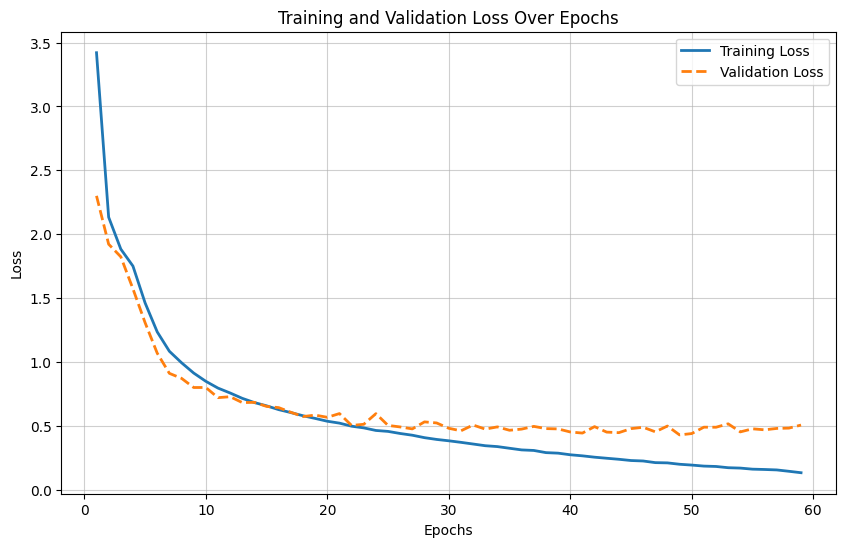

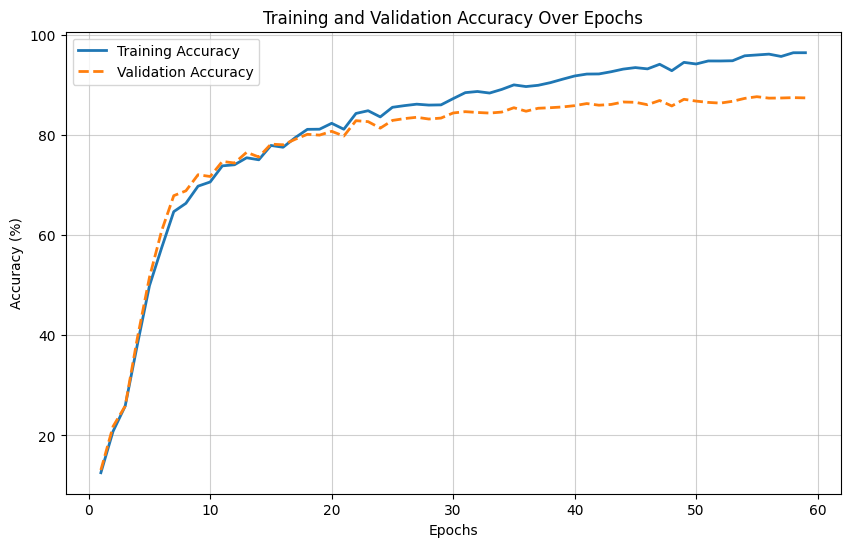

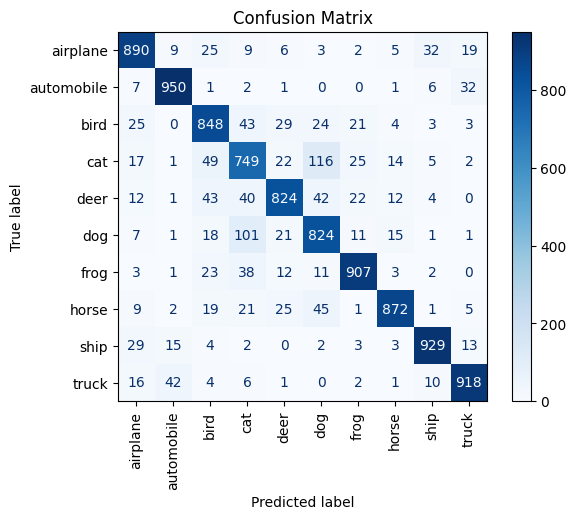

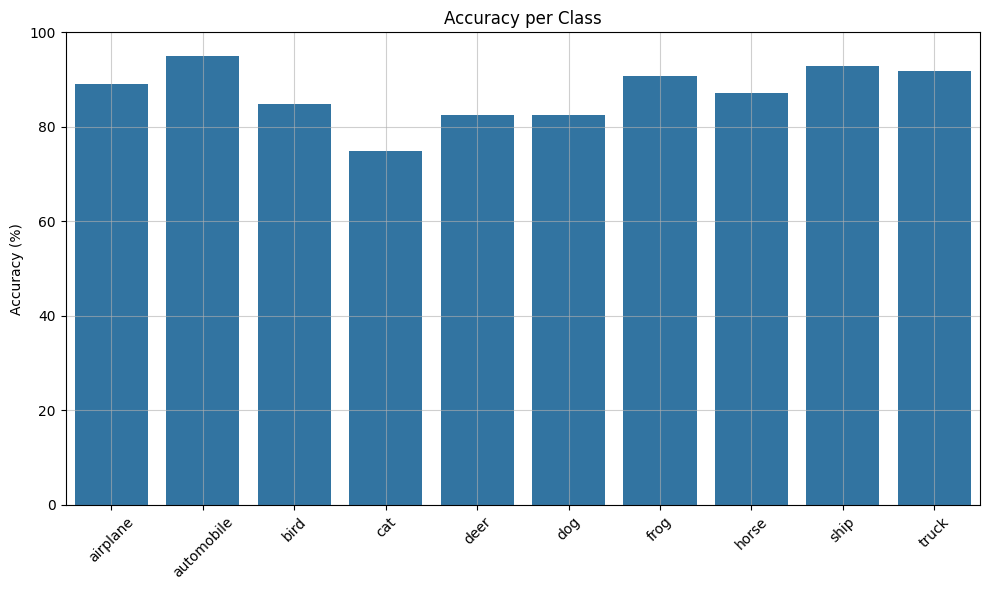

Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.89      0.88      1000
  automobile       0.93      0.95      0.94      1000
        bird       0.82      0.85      0.83      1000
         cat       0.74      0.75      0.74      1000
        deer       0.88      0.82      0.85      1000
         dog       0.77      0.82      0.80      1000
        frog       0.91      0.91      0.91      1000
       horse       0.94      0.87      0.90      1000
        ship       0.94      0.93      0.93      1000
       truck       0.92      0.92      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



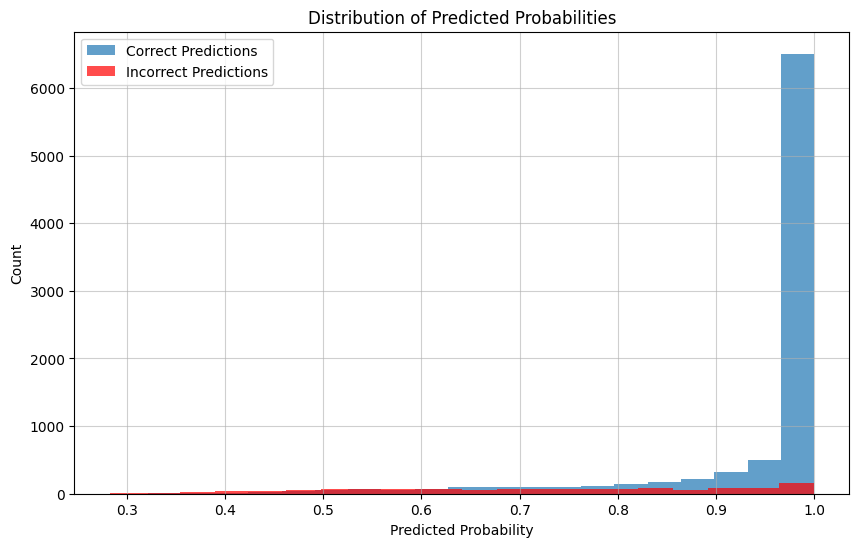

In [ ]:
def train_best_model(best_params, patience=10, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lr, batch_size, dim, n_heads = best_params['learning_rate'], best_params['batch_size'], best_params['dim'], best_params['n_heads']
    depth, dropout, nb_features = best_params['depth'], best_params['dropout'], best_params['nb_features']
    optimizer_type = best_params['optimizer']

    # Load data
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_tuple, std_tuple)
    ])
    trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset_augmented, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = Performer(num_classes=10, dim=dim, n_heads=n_heads, depth=depth, dropout=dropout, nb_features=nb_features)
    model.to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr * 10, momentum=0.9, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    else:  # Adam
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(trainloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_train_loss = running_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # Compute training accuracy at the end of epoch
        train_acc, _ = evaluate_model(model, trainloader, device)
        train_accuracies.append(train_acc)

        # Validation
        val_loss = validate_model(model, testloader, criterion, device)
        val_losses.append(val_loss)
        val_acc, _ = evaluate_model(model, testloader, device)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping activated!")
            break

    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))

    # Plot training curves
    plot_losses(train_losses, val_losses, len(train_losses))
    plot_accuracies(train_accuracies, val_accuracies, len(val_accuracies))

    # Plot confusion matrix
    plot_confusion_matrix(model, testloader, device, testset.classes)

    # Plot class accuracy
    plot_class_accuracy(model, testloader, device, testset.classes)

    # Show classification report
    show_classification_report(model, testloader, device, testset.classes)

    # Plot distribution of predictions (confidence)
    plot_prediction_distribution(model, testloader, device, testset.classes)

    return model

model = train_best_model(best_params_final, patience=10, num_epochs=100)